In [1]:
# Impor library yang diperlukan
import tensorflow as tf  # Library utama untuk deep learning dan pengelolaan tensor
from tensorflow import keras  # API tingkat tinggi untuk membangun model
from tensorflow.keras import layers  # Modul untuk mendefinisikan lapisan seperti Dense dan Conv2D
from tensorflow.keras.applications import VGG16  # Modul untuk memuat VGG16 pre-trained
import numpy as np  # Library untuk operasi numerik dan manipulasi array
import matplotlib.pyplot as plt  # Library untuk visualisasi data seperti grafik dan gambar

In [2]:
# Memuat dataset MNSIT
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Memuat dataset MNSIT: 60.000 data latih dan 10.000 data uji dari Keras

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Menormalkan data
x_train = x_train / 255.0  # Normalisasi nilai piksel dari 0-255 menjadi 0-1 untuk stabilitas pelatihan
x_test = x_test / 255.0  # Normalisasi data uji agar konsisten dengan data latih
x_train = x_train[..., np.newaxis]  # Menambah dimensi kanal menjadi (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]  # Menambah dimensi kanal menjadi (10000, 28, 28, 1)

In [4]:
# Fungsi untuk memproses gambar dalam pipeline
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Mengubah ukuran gambar ke 224x224 untuk VGG16
    image = tf.image.grayscale_to_rgb(image)  # Mengonversi grayscale (1 kanal) ke RGB (3 kanal)
    return image, label  # Mengembalikan gambar yang diproses dan labelnya

In [5]:
# Membuat dataset dengan tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Membuat dataset dari tensor slices untuk data latih
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# Membuat dataset dari tensor slices untuk data uji
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
# Memproses gambar dalam batch 32, dengan paralelisasi dan prefetch untuk efisiensi
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
# Memproses data uji dengan cara yang sama


In [6]:
# Memuat model VGG16 pre-trained
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Memuat VGG16 dengan bobot ImageNet, tanpa lapisan klasifikasi atas, untuk input 224x224x3

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# Tahap 1: Sebelum Fine-Tuning (hanya melatih lapisan kustom)
base_model.trainable = False  # Membekukan seluruh lapisan VGG16 agar tidak dilatih
model = keras.Sequential([
    base_model,  # Menggunakan VGG16 sebagai dasar ekstraksi fitur
    layers.GlobalAveragePooling2D(),  # Merata-ratakan peta fitur menjadi vektor
    layers.Dropout(0.5),  # Menambahkan dropout untuk mencegah overfitting
    layers.Dense(256, activation='relu'),  # Lapisan fully connected dengan 256 unit
    layers.Dense(10, activation='softmax')  # Lapisan output untuk 10 kelas (digit 0-9)
])

In [8]:
# Mengompilasi model sebelum fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Optimizer Adam dengan learning rate standar untuk tahap awal

In [9]:
# Melatih model sebelum fine-tuning
print("Melatih model sebelum fine-tuning...")
model.fit(train_dataset, epochs=3)  # Melatih hanya lapisan kustom selama 3 epoch untuk efisiensi

Melatih model sebelum fine-tuning...
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.6387 - loss: 1.1131
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8407 - loss: 0.4903
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.8558 - loss: 0.4408


In [10]:
# Mengevaluasi model sebelum fine-tuning
test_loss_before, test_acc_before = model.evaluate(test_dataset)
# Menguji model pada dataset uji sebelum fine-tuning
print(f'Akurasi uji sebelum fine-tuning: {test_acc_before:.4f}')  # Menampilkan akurasi sebelum fine-tuning

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9277 - loss: 0.2330
Akurasi uji sebelum fine-tuning: 0.9392


In [11]:
# Tahap 2: Sesudah Fine-Tuning (melatih ulang sebagian lapisan VGG16)
for layer in base_model.layers[:15]:  # Membekukan 15 lapisan pertama VGG16
    layer.trainable = False
for layer in base_model.layers[15:]:  # Membuka lapisan setelahnya untuk fine-tuning
    layer.trainable = True

In [12]:
# Mengompilasi ulang model untuk fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Menggunakan learning rate lebih kecil untuk fine-tuning agar stabil

In [13]:
# Melatih model dengan fine-tuning
print("Melatih model dengan fine-tuning...")
model.fit(train_dataset, epochs=5)  # Melatih model dengan fine-tuning selama 5 epoch

Melatih model dengan fine-tuning...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.9540 - loss: 0.1500
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9898 - loss: 0.0377
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9922 - loss: 0.0256
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9939 - loss: 0.0209
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.9947 - loss: 0.0172


In [14]:
# Mengevaluasi model setelah fine-tuning
test_loss_after, test_acc_after = model.evaluate(test_dataset)
# Menguji model pada dataset uji setelah fine-tuning
print(f'Akurasi uji setelah fine-tuning: {test_acc_after:.4f}')  # Menampilkan akurasi setelah fine-tuning

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9909 - loss: 0.0299
Akurasi uji setelah fine-tuning: 0.9923


In [15]:
# Membandingkan hasil
print(f"\nPerbandingan Akurasi:")
print(f"Sebelum fine-tuning: {test_acc_before:.4f}")
print(f"Sesudah fine-tuning: {test_acc_after:.4f}")
print(f"Perbedaan: {(test_acc_after - test_acc_before):.4f}")  # Menampilkan selisih akurasi


Perbandingan Akurasi:
Sebelum fine-tuning: 0.9392
Sesudah fine-tuning: 0.9923
Perbedaan: 0.0531


In [16]:
# Fungsi untuk visualisasi gambar dan prediksi
def plot_images_with_labels(images, true_labels, predictions):
    plt.figure(figsize=(10, 10))  # Membuat figure dengan ukuran 10x10 inci
    for i in range(9):  # Loop untuk 9 gambar pertama
        plt.subplot(3, 3, i+1)  # Menambah subplot dalam grid 3x3
        plt.imshow(images[i])  # Menampilkan gambar ke-i
        pred_label = np.argmax(predictions[i])  # Mengambil label prediksi dari probabilitas tertinggi
        plt.title(f'Pred: {pred_label} | True: {true_labels[i]}')  # Menampilkan prediksi dan label sebenarnya
        plt.axis('off')  # Menghilangkan sumbu untuk tampilan bersih
    plt.show()  # Menampilkan semua subplot


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


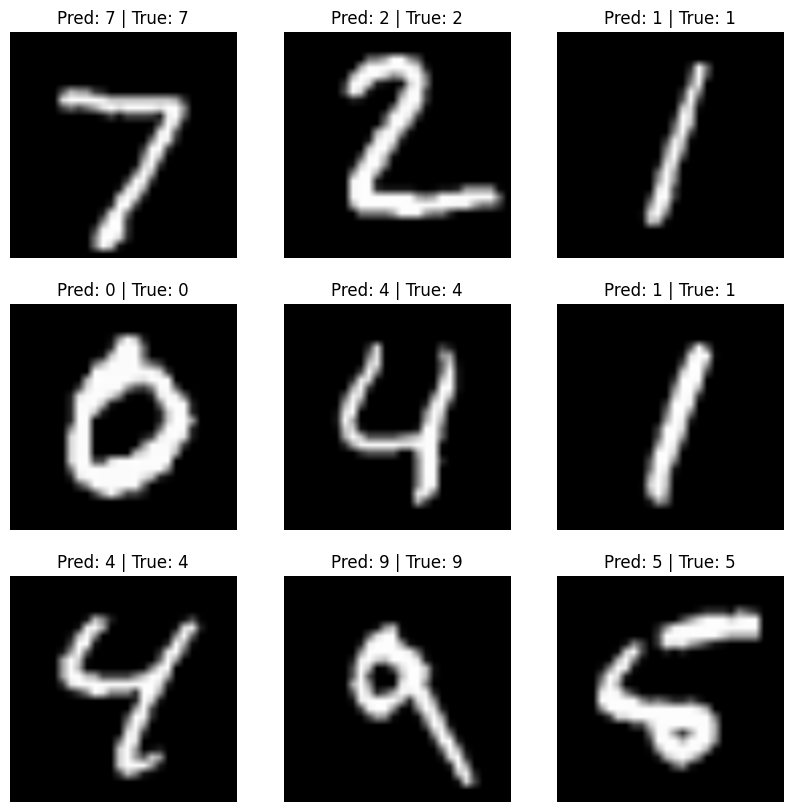

In [17]:
# Membuat prediksi dan visualisasi setelah fine-tuning
test_images = x_test[:9]  # Mengambil 9 gambar pertama dari data uji (bentuk awal: (9, 28, 28, 1))
test_images_resized = tf.image.resize(test_images, [224, 224])  # Mengubah ukuran ke 224x224, tetap mempertahankan kanal
test_images_rgb = tf.image.grayscale_to_rgb(test_images_resized)  # Mengonversi ke RGB (9, 224, 224, 3)
predictions = model.predict(test_images_rgb)  # Membuat prediksi untuk 9 gambar setelah fine-tuning
plot_images_with_labels(test_images_rgb.numpy(), y_test[:9], predictions)  # Menampilkan gambar dengan label